In [ ]:
import matplotlib.pyplot as plt
import datetime
import os
import io
import re
import numpy as np

from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Dense,Flatten,SimpleRNN,Conv1D,Bidirectional,GRU,BatchNormalization,Dropout,Input,Embedding,TextVectorization


from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy,CategoricalAccuracy,SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins import projector

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2024-02-02 07:51:19--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  31.7MB/s    in 0.2s    

2024-02-02 07:51:19 (31.7 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]



In [ ]:
!unzip "/content/fra-eng.zip" -d "/content/datasets/"

Archive:  /content/fra-eng.zip
  inflating: /content/datasets/_about.txt  
  inflating: /content/datasets/fra.txt  


# **Data Processing**

In [ ]:
text_dataset = tf.data.TextLineDataset('/content/datasets/fra.txt')

In [ ]:
for i in text_dataset.take(1):
  print(i)

tf.Tensor(b'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)', shape=(), dtype=string)


In [ ]:
Vocab_Size= 20000
Sequence_Length = 64
Embedding_Dim = 300

In [ ]:
english_vectorize_layer = TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens = Vocab_Size,
    output_mode = "int",
    output_sequence_length = Sequence_Length

)

In [ ]:
french_vectorize_layer = TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens = Vocab_Size,
    output_mode = "int",
    output_sequence_length = Sequence_Length

)

In [ ]:
def selector(input_text):
  split_text = tf.strings.split(input_text,'\t')
  return {'input_1': split_text[0:1],'input_2': '[start] ' + split_text[1:2]},split_text[1:2]+' [end]'

In [ ]:
split_dataset = text_dataset.map(selector)

In [ ]:
for i in split_dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! [end]'], dtype=object)>)


In [ ]:
def seperator(input_text):
  split_text = tf.strings.split(input_text,'\t')
  return split_text[0:1],'[start] '+split_text[1:2]+" [end]"

In [ ]:
init_dataset = text_dataset.map(seperator)

In [ ]:
for i in init_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Va ! [end]'], dtype=object)>)


In [ ]:
english_training_data = init_dataset.map(lambda x,y :x)
english_vectorize_layer.adapt(english_training_data)

In [ ]:
french_training_data = init_dataset.map(lambda x,y :y)
french_vectorize_layer.adapt(french_training_data)

In [ ]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
dataset = split_dataset.map(vectorizer)

In [ ]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
for i in dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[104,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [ ]:
english_vectorize_layer.get_vocabulary()[45]

'go'

In [ ]:
french_vectorize_layer.get_vocabulary()[2]

'start'

In [ ]:
Batch_Size = 64

In [ ]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
dataset = dataset.shuffle(2048).unbatch().batch(Batch_Size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
Num_Batches = int(200000/Batch_Size)
Num_Batches

3125

In [ ]:
train_dataset = dataset.take(int(0.9*Num_Batches))
val_dataset = dataset.skip(int(0.9*Num_Batches))

In [ ]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
0.9*Num_Batches

2812.5

# Model Building

In [ ]:
Num_Units=256

In [ ]:
##Encoder
input = Input(shape=(Sequence_Length),dtype='int64',name='input_1')
x = Embedding(Vocab_Size,Embedding_Dim)(input)
encoded_input = Bidirectional(GRU(Num_Units))(x)

In [ ]:
##Decoder
shifted_target = Input(shape=(Sequence_Length),dtype='int64',name='input_2')
x = Embedding(Vocab_Size,Embedding_Dim)(shifted_target)

x = GRU(Num_Units*2,return_sequences=True)(x,initial_state=encoded_input)

In [ ]:
##Output
x = Dropout(0.5)(x)
target = Dense(Vocab_Size,activation='softmax')(x)
seq2seq =  Model([input,shifted_target],target)

In [ ]:

seq2seq.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

In [ ]:
j=tf.constant([2,4,6,7,8])
print(j)
print([False if y==0 else True for y in range(len(j))])
j = tf.boolean_mask(j,[False if y==0 else True for y in range(len(j))])
print(j)

tf.Tensor([2 4 6 7 8], shape=(5,), dtype=int32)
[False, True, True, True, True]
tf.Tensor([4 6 7 8], shape=(4,), dtype=int32)


In [ ]:
class BLEU(tf.keras.metrics.Metric):
  def __init__(self,name='bleu_score'):
    super(BLEU,self).__init__()
    self.bleu_score=0

  def update_state(self,y_true,y_pred,sample_weight=None):
    y_pred = tf.argmax(y_pred,axis=-1)
    self.bleu_score=0
    for  i,j in zip(y_pred,y_true):
      tf.autograph.experimental.set_loop_options()


      total_word = tf.math.count_nonzero(i)
      total_matches=0
      for word in i:
        if word==0:
          break
        for q in range(len(j)):
          if j[q]==0:
            break
          if j[q]==word:
            total_matches+=1
            j = tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
            break
      self.bleu_score+=total_matches/total_word


  def result(self):
    return self.bleu_score/Batch_Size

In [ ]:

seq2seq.compile(loss='SparseCategoricalCrossentropy',optimizer=Adam(1e-4),
                metrics=[BLEU()],run_eagerly=True)

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/seq2seq.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
history = seq2seq.fit(train_dataset,epochs=5,validation_data=val_dataset,callbacks=[model_checkpoint_callback])

Epoch 1/5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
   1154/Unknown - 2530s 2s/step - loss: 0.8807 - bleu_1: 0.2665

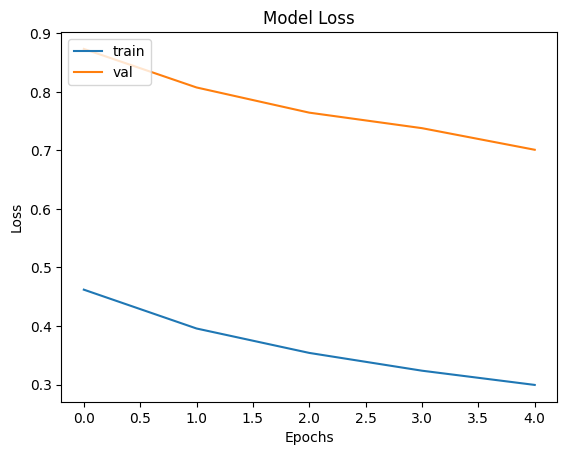

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train','val'],loc='upper left')
plt.show()

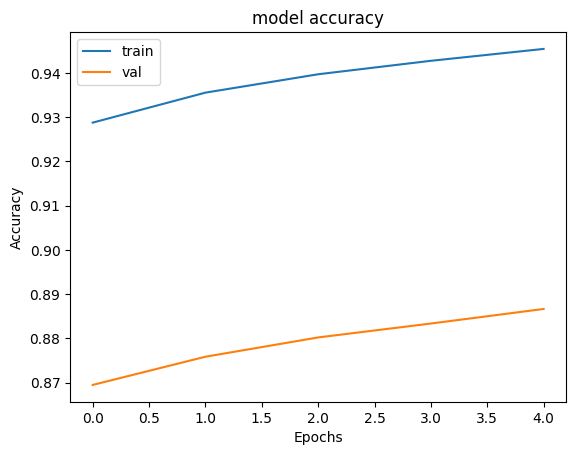

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/seq2seq.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

# Testing

In [ ]:
index_to_word = {index:word for index,word in zip(range(len(french_vectorize_layer.get_vocabulary())),french_vectorize_layer.get_vocabulary())}
print(index_to_word)

{0: '', 1: '[UNK]', 2: 'start', 3: 'end', 4: 'je', 5: 'de', 6: 'pas', 7: 'que', 8: 'ne', 9: 'le', 10: 'à', 11: 'la', 12: 'vous', 13: 'tom', 14: 'il', 15: 'est', 16: 'tu', 17: 'un', 18: 'ce', 19: 'a', 20: 'nous', 21: 'les', 22: 'une', 23: 'en', 24: 'jai', 25: 'suis', 26: 'pour', 27: 'me', 28: 'faire', 29: 'cest', 30: 'dans', 31: 'plus', 32: 'des', 33: 'elle', 34: 'ça', 35: 'tout', 36: 'qui', 37: 'te', 38: 'fait', 39: 'du', 40: 'ma', 41: 'mon', 42: 'veux', 43: 'avec', 44: 'se', 45: 'au', 46: 'si', 47: 'et', 48: 'cette', 49: 'sont', 50: 'y', 51: 'quil', 52: 'très', 53: 'pense', 54: 'cela', 55: 'nest', 56: 'son', 57: 'sur', 58: 'sais', 59: 'votre', 60: 'pourquoi', 61: 'dit', 62: 'temps', 63: 'être', 64: 'été', 65: 'était', 66: 'peux', 67: 'moi', 68: 'nai', 69: 'chose', 70: 'ici', 71: 'jamais', 72: 'ils', 73: 'lui', 74: 'comment', 75: 'où', 76: 'bien', 77: 'estce', 78: 'ton', 79: 'quelque', 80: 'vraiment', 81: 'beaucoup', 82: 'on', 83: 'besoin', 84: 'dire', 85: 'tous', 86: 'toi', 87: 'perso

In [ ]:
word_to_index = {word:index for index,word in zip(range(len(french_vectorize_layer.get_vocabulary())),french_vectorize_layer.get_vocabulary())}
print(word_to_index)

{'': 0, '[UNK]': 1, 'start': 2, 'end': 3, 'je': 4, 'de': 5, 'pas': 6, 'que': 7, 'ne': 8, 'le': 9, 'à': 10, 'la': 11, 'vous': 12, 'tom': 13, 'il': 14, 'est': 15, 'tu': 16, 'un': 17, 'ce': 18, 'a': 19, 'nous': 20, 'les': 21, 'une': 22, 'en': 23, 'jai': 24, 'suis': 25, 'pour': 26, 'me': 27, 'faire': 28, 'cest': 29, 'dans': 30, 'plus': 31, 'des': 32, 'elle': 33, 'ça': 34, 'tout': 35, 'qui': 36, 'te': 37, 'fait': 38, 'du': 39, 'ma': 40, 'mon': 41, 'veux': 42, 'avec': 43, 'se': 44, 'au': 45, 'si': 46, 'et': 47, 'cette': 48, 'sont': 49, 'y': 50, 'quil': 51, 'très': 52, 'pense': 53, 'cela': 54, 'nest': 55, 'son': 56, 'sur': 57, 'sais': 58, 'votre': 59, 'pourquoi': 60, 'dit': 61, 'temps': 62, 'être': 63, 'été': 64, 'était': 65, 'peux': 66, 'moi': 67, 'nai': 68, 'chose': 69, 'ici': 70, 'jamais': 71, 'ils': 72, 'lui': 73, 'comment': 74, 'où': 75, 'bien': 76, 'estce': 77, 'ton': 78, 'quelque': 79, 'vraiment': 80, 'beaucoup': 81, 'on': 82, 'besoin': 83, 'dire': 84, 'tous': 85, 'toi': 86, 'personne'

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence = english_vectorize_layer([english_sentence])
  shifted_target = '[start]'

  for i in range(Sequence_Length):
    tokenize_shifted_target = french_vectorize_layer([shifted_target])

    output = model.predict([tokenized_english_sentence,tokenize_shifted_target])

    french_sentence = tf.argmax(output,axis=-1)
    french_word_index = french_sentence[0][i].numpy()
    current_word = index_to_word[french_word_index]

    if current_word =='end':
      break

    shifted_target+=" "+current_word
  return shifted_target[8:]

In [ ]:
translator("have you ever watched a soccer match under the rain?")

1/1 [==============================] - 0s 25ms/step


'astu déjà vu un accident de [UNK]'

In [ ]:
#seq2seq.save('seq2seq.h5')